# A simple simulator for Stratified media under normal incidence

## Imports

In [112]:
import jax
import jax.numpy as jnp
import numpy as onp
import matplotlib.pyplot as plt

In [113]:
import sax
import meow
import meow.eme.propagate
from sax.backends import circuit_backends
from sax.saxtypes import scoo
sax_backend = meow.eme.sax._validate_sax_backend("klu")

## Layer Stack

In [159]:
ns = [2+0.04j]
ds = [1]
wl = 0.523
xi = jnp.cumsum(jnp.array(ds))

## Fresnel and Propagation

In [160]:
def fresnel_mirror_ij(ni=1.0, nj=1.0):
    """Model a (fresnel) interface between twoo refractive indices

    Args:
        ni: refractive index of the initial medium
        nf: refractive index of the final
    """
    r_fresnel_ij = (ni - nj) / (ni + nj)  # i->j reflection
    t_fresnel_ij = 2 * ni / (ni + nj)  # i->j transmission
    r_fresnel_ji = -r_fresnel_ij  # j -> i reflection
    t_fresnel_ji = (1 - r_fresnel_ij**2) / t_fresnel_ij  # j -> i transmission
    sdict = {
        ("left", "left"): r_fresnel_ij,
        ("left", "right"): t_fresnel_ij,
        ("right", "left"): t_fresnel_ji,
        ("right", "right"): r_fresnel_ji,
    }
    return sdict


def propagation_i(ni=1.0, di=0.5, wl=wl):
    """Model the phase shift acquired as a wave propagates through medium A

    Args:
        ni: refractive index of medium (at wavelength wl)
        di: [μm] thickness of layer
        wl: [μm] wavelength
    """
    prop_i = jnp.exp(1j * 2 * jnp.pi * ni * di / wl)
    sdict = {
        ("left", "right"): prop_i,
        ("right", "left"): prop_i,
    }
    return sdict

## Layers
let's set up the sax components for the different layers

In [161]:
identity = fresnel_mirror_ij(1, 1)

In [162]:
propagations=[propagation_i(ni, di) for ni, di in zip(ns, ds)]
propagations=[identity]+propagations+[identity]
propagations = {f"p_{i}": sax.sdense(p) for i, p in enumerate(propagations)}

In [163]:
padded_ns = [1]+ns+[1]
interfaces=[fresnel_mirror_ij(ni, nj) for ni, nj in zip(padded_ns, padded_ns[1:])]
#interfaces=[identity]+interfaces+[identity]
interfaces = {f"i_{i}_{i+1}": sax.sdense(p) for i, p in enumerate(interfaces)}

## Propagate Interface Pairs 
Combine successive propagation sections and interfaces into Propagate Interface Pairs (pi_pairs).

In [164]:
pairs = meow.eme.propagate.pi_pairs(propagations, interfaces, sax_backend)

## Accumulate
Split the whole device into left and right sections with the split moving from left to right

In [165]:
l2rs = meow.eme.propagate.l2r_matrices(pairs, identity, sax_backend)
r2ls = meow.eme.propagate.r2l_matrices(pairs, sax_backend)

## Excite from the left

In [166]:
ex_l = jnp.array([1])
ex_r = jnp.array([0])

## Calculate Amplitudes
TODO: explain how it works

In [167]:
forwards, backwards = meow.eme.propagate.propagate(l2rs, r2ls, ex_l, ex_r)

In [168]:
def fields(padded_ns, xi, forwards, backwards, x):
    """Calculates the fields within a stack at given positions x
    Attention xi > 0
    """
    xi = onp.concatenate([[-onp.inf, 0], xi, [onp.inf]])
    E_tot = onp.zeros((len(x),), dtype=complex)
    for n, forward, backward, x_min, x_max in zip(padded_ns, forwards, backwards, xi, xi[1:]):
        print(f"{n}: {x_min} - {x_max}: -> {forward[0]}; <- {backward[0]}")
        i_min = onp.argmax(x >= x_min)
        i_max = onp.argmax(x > x_max)
        if i_max == 0:
            x_ = x[i_min:]
        else:
            x_ = x[i_min:i_max]

        if onp.isinf(x_min):
            x_local = x_
        else:
            x_local = x_ - x_min
        E_local = forward*onp.exp(2j * onp.pi * n / wl * x_local)
        E_local += backward*onp.exp(-2j * onp.pi * n / wl * x_local)

        if i_max == 0:
            E_tot[i_min:] = E_local
        else:
            E_tot[i_min:i_max] = E_local
            
    return E_tot

In [169]:
x = jnp.linspace(-0.5, 2, 400)
field = fields(padded_ns, xi, forwards, backwards, x)

1: -inf - 0.0: -> (1+0j); <- (-0.4008501745111759-0.09674582350902057j)
(2+0.04j): 0.0 - 1.0: -> (1.3015098292145932-0.03638991524473367j); <- (-0.0993403452965833-0.13313573875375437j)
1: 1.0 - inf: -> (0.2209528060765665-0.48918360894612245j); <- 0j


Text(0, 0.5, '$|E(x)|$')

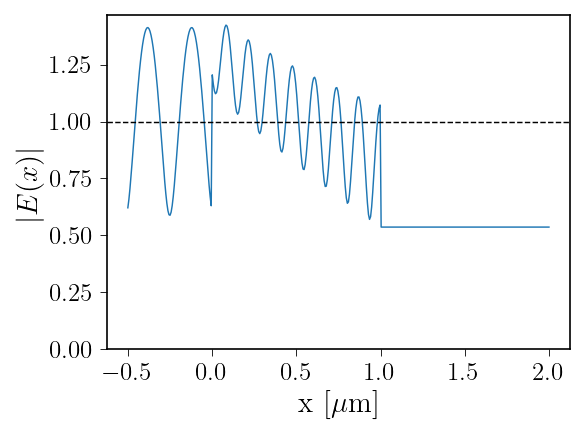

In [173]:
plt.plot(x, onp.abs(field))
plt.axhline(1, color="k", linestyle="--")
plt.ylim((0, None))
plt.xlabel("x [$\mu$m]")
plt.ylabel("$|E(x)|$")